# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.utils import to_categorical

# Data Visualization

In [4]:
data = pd.read_csv(r'C:Downloads\fer2013.csv')
data['Usage'][1000:1020].tail(5)
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


# Data Preparation and Ploting

In [5]:
def prepare_data(data):

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
      
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [6]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Training Data(pixels)

In [6]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
#print(val_image_array)

In [39]:
print(train_image_array[0])
#print(type(train_image_array[0][0][0]))

[[ 70.  80.  82. ...  52.  43.  41.]
 [ 65.  61.  58. ...  56.  52.  44.]
 [ 50.  43.  54. ...  49.  56.  47.]
 ...
 [ 91.  65.  42. ...  72.  56.  43.]
 [ 77.  82.  79. ... 105.  70.  46.]
 [ 77.  72.  84. ... 106. 109.  82.]]


In [8]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255
#print(val_images)
print(train_images[0][0],'\ntype: ', type(train_images[0][0][0][0]))

[[0.27450982]
 [0.3137255 ]
 [0.32156864]
 [0.28235295]
 [0.22745098]
 [0.22745098]
 [0.23529412]
 [0.24705882]
 [0.21176471]
 [0.22745098]
 [0.23529412]
 [0.1882353 ]
 [0.34901962]
 [0.4509804 ]
 [0.4745098 ]
 [0.46666667]
 [0.4509804 ]
 [0.43137255]
 [0.38431373]
 [0.35686275]
 [0.32941177]
 [0.32941177]
 [0.3529412 ]
 [0.3882353 ]
 [0.43137255]
 [0.49411765]
 [0.56078434]
 [0.6       ]
 [0.61960787]
 [0.67058825]
 [0.6627451 ]
 [0.6745098 ]
 [0.6627451 ]
 [0.64705884]
 [0.5058824 ]
 [0.43137255]
 [0.44313726]
 [0.41960785]
 [0.37254903]
 [0.30980393]
 [0.25882354]
 [0.24313726]
 [0.21960784]
 [0.22352941]
 [0.23921569]
 [0.20392157]
 [0.16862746]
 [0.16078432]] 
type:  <class 'numpy.float32'>


# labels

In [9]:
train_labels = to_categorical(train_image_label)
print(train_labels[0:15],'\n', train_image_label[0:15])
#print(train_labels.itemsize, train_image_label.itemsize )
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]] 
 [0 0 2 4 6 2 4 3 3 2 0 6 6 6 3]


# ploting

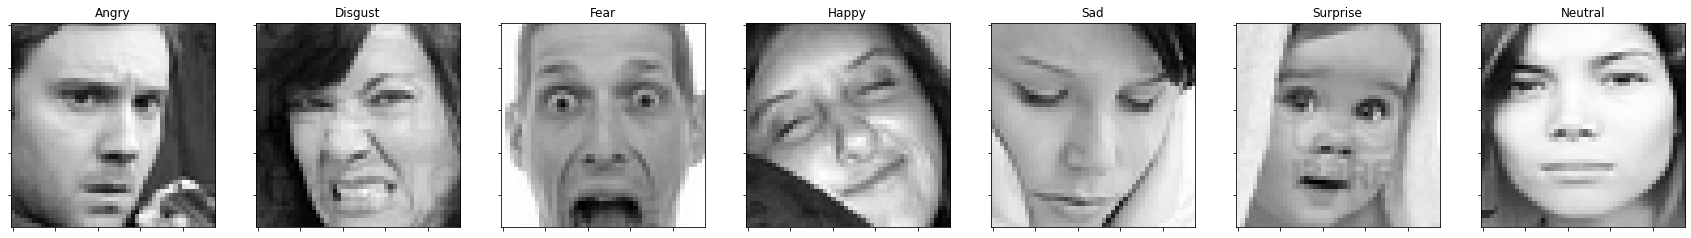

In [10]:
plot_all_emotions()

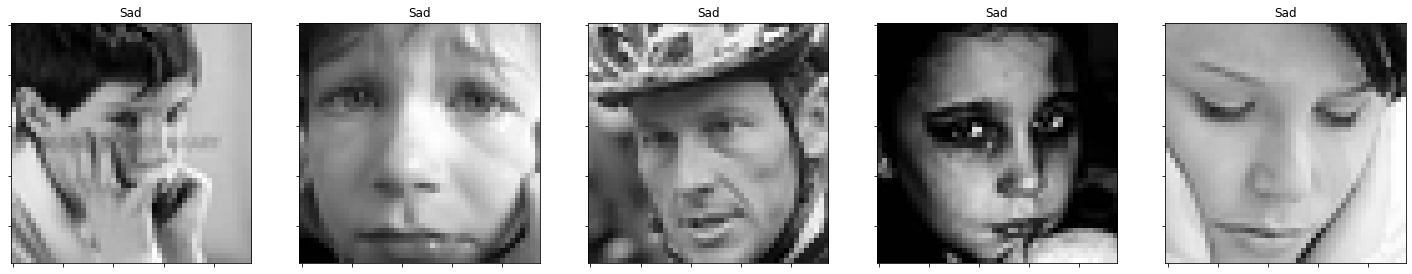

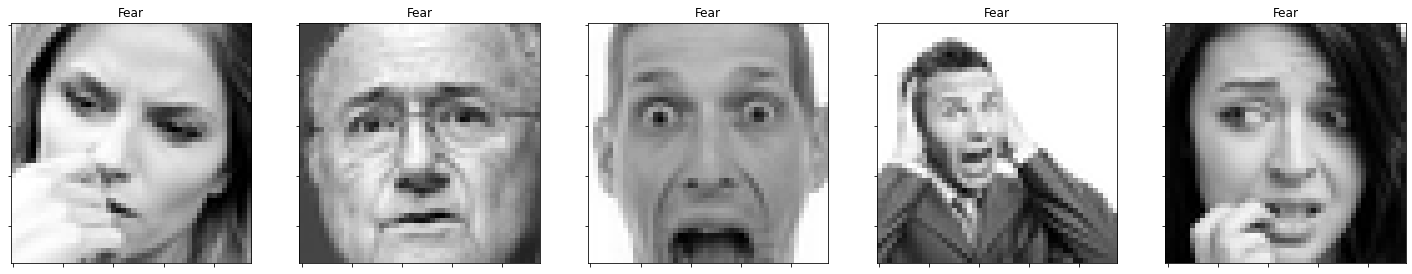

In [40]:
plot_examples(label=4)
plot_examples(label=2) 

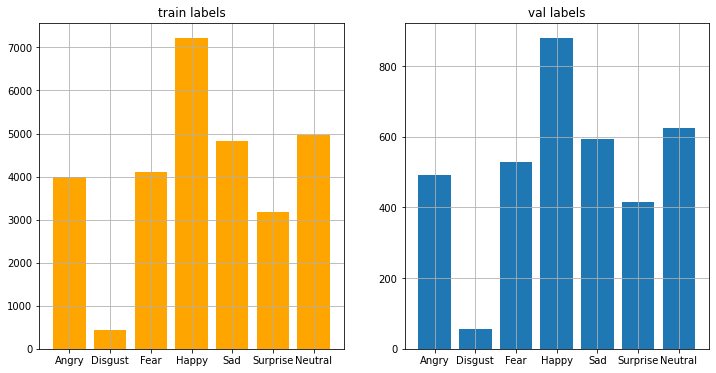

In [12]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [13]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [14]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# Augmentation

# Convolution and Compiling

In [15]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [16]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


c:\users\win10\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

# fiting the model

In [19]:
def MyModel():
    history = model.fit(train_images, train_labels,
                        validation_data=(val_images, val_labels),
                            class_weight = class_weight,
                            epochs=12,
                            batch_size=64)
MyModel()

Epoch 1/12
449/449 [==============================] - 47s 103ms/step - loss: 0.2723 - accuracy: 0.3045 - val_loss: 1.6579 - val_accuracy: 0.3803
Epoch 2/12
449/449 [==============================] - 48s 106ms/step - loss: 0.2309 - accuracy: 0.4244 - val_loss: 1.4601 - val_accuracy: 0.4514
Epoch 3/12
449/449 [==============================] - 45s 100ms/step - loss: 0.2095 - accuracy: 0.4793 - val_loss: 1.3889 - val_accuracy: 0.4759
Epoch 4/12
449/449 [==============================] - 48s 108ms/step - loss: 0.1969 - accuracy: 0.5134 - val_loss: 1.3253 - val_accuracy: 0.5046
Epoch 5/12
449/449 [==============================] - 47s 106ms/step - loss: 0.1863 - accuracy: 0.5417 - val_loss: 1.3070 - val_accuracy: 0.5099
Epoch 6/12
449/449 [==============================] - 43s 95ms/step - loss: 0.1773 - accuracy: 0.5643 - val_loss: 1.2909 - val_accuracy: 0.5191
Epoch 7/12
449/449 [==============================] - 45s 101ms/step - loss: 0.1687 - accuracy: 0.5880 - val_loss: 1.2549 - val_acc

In [22]:
def ModelSave(): 
    model.save(r'G:\1-uni\پردازش\saved model')
ModelSave()

INFO:tensorflow:Assets written to: G:\1-uni\پردازش\saved model\assets


In [23]:
from tensorflow import keras
#model = keras.models.load_model(r'G:\1-uni\پردازش\saved model')

# accuracy determining

In [24]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 1s 12ms/step - loss: 1.4027 - accuracy: 0.5397
test accuracy: 0.5397046804428101


In [25]:
pred_test_labels = model.predict(test_images)

# ploting the result

In [ ]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [ ]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

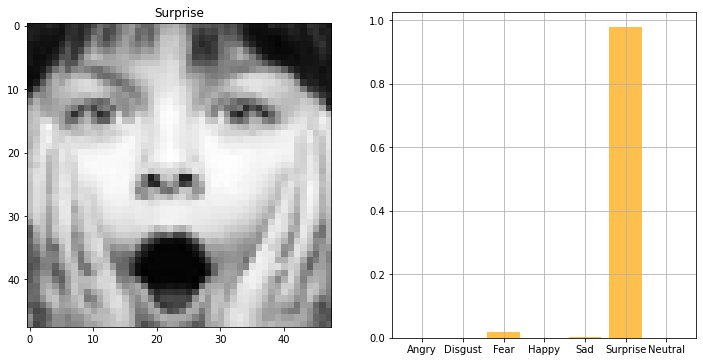

In [26]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 120)

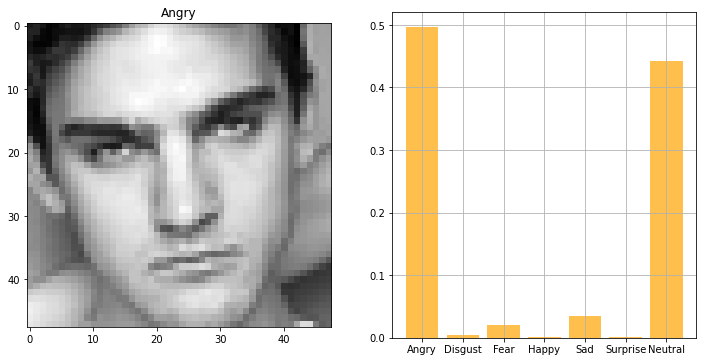

In [41]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 50)

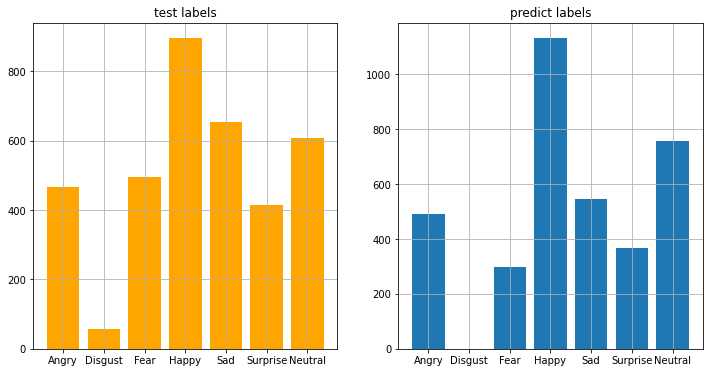

In [28]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

# train and test comparing

In [29]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

C:\Users\win10\AppData\Local\Temp/ipykernel_6060/370141153.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


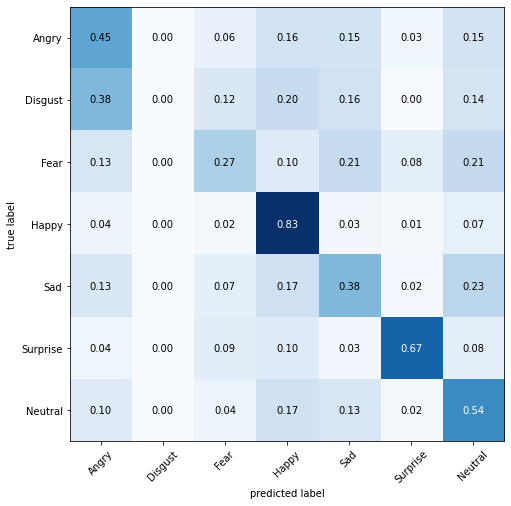

In [30]:
%matplotlib inline
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()